# Práctica de Optical Flow

## Ejercicios 1 y 2

### Marc Balle Sánchez

### Introducción

Esta práctica contiene dos ejercicios introductorios al flujo óptico. En concreto, se hace uso de la implementación del algoritmo de Lucas y Kanade de OpenCV. Para ello, se plantea modificar el código ya presente en la documentación de OpenCV. Como base de datos se propone la proporcionada por la página Changedetection.net (http://changedetection.net/), de donde se descargarán algunas secuencias de imágenes. 

Primer de todo se importan las librerías necesarias para el desarrollo del código.

In [1]:
import os
import glob
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

## Ejercicio 1

Este primer ejercicio consiste en conseguir trazar las líneas de flujo de los objetos en movimiento de la escena. Para ello se emplea la secuencia _highway_ , en la que se muestran una serie de coches circulando. Para ello, se han realizado tres experimentos distintos sobre el código original, mostrados al final. 

Las líneas de flujo se trazan para una serie de puntos clave que se van evaluando a cada iteración del algoritmo. Estos puntos clave son definidos inicialmente por el algorimo de detección de bordes de Shi Tomasi, una modificación del de Harris. Después, a cada iteración se van seleccionando aquellos que el algoritmo de Lucas y Kanade (LK) ha sido capaz de estimar su movimento entre frames. Cabe mencionar que los puntos clave se seleccionan con un detector de esquinas ya que son este tipo de puntos los que permiten no desembocar en problemas, como el de la apertura. 

Primero de todo se definen alguno parámetros clave para la detección de esquinas y para el algoritmo LK.

In [2]:
#shi tomasi corner detection parameters
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.2, #0.3
                       minDistance = 3, #7
                       blockSize = 3 ) #7

#lucas kanade optical flow parameters
lk_params = dict( winSize  = (15,15), #15,15
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

Se definen una serie de colores aleatorios que servirán para dibujar las lineas de flujo

In [3]:
color = np.random.randint(0,255,(100,3))

Llegado a este punto cabe destacar que los archivos seleccionados son secuencias de imágenes, no un vídeo montado. Sin embargo, ello no influye en el desarrollo de esta práctica, ya que el resultado que se espera es el último frame de la secuencia con las líneas de flujo pintadas sobre él. Así pues, bastará con ir iterando sobre las distintas imágenes dentro de la carpeta.

Se carga la primera imagen. Como el algoritmo funciona con un solo canal, se transforman las imágenes a blano y negro. 

In [4]:
# first image
path = './input/highway/'
if sorted(os.listdir(path))[0] == '.DS_Store':
    os.system("rm ./input/highway/.DS_Store")

old_frame = cv.imread(path+sorted(os.listdir(path))[0])
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)

Se seleccionan los puntos clave a seguir con el algoritmo de Shi Tomasi. 

In [5]:
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

Se crea una máscara que ayudará en el dibujo de la líneas de flujo.

In [6]:
mask = np.zeros_like(old_frame)

Finalmente se procede a iterar sobre los distintos frames de la imagen, calculando el flujo óptico para cada uno de los puntos seleccionados. La función `calcOpticalFlowPyrLK` se encarga de calcular el movimiento de un conjunto de puntos `p0` de un frame `old_gray` al siguiente `frame_gray`. El resultado de este movimiento son los puntos `p1`. Además devuelve una variable `st` indicando para qué puntos ha sido posible calcular su flujo y cuáles no. Esta variable permitirá filtrar los puntos adecuados para continuar con el proceso. Finalmente se dibujan líneas de flujo teniendo en cuenta el inicio y final de movimiento de cada punto en `p0` y `p1`. El resutlado se almacena en el directorio `./output/highway/`. 

In [7]:
for filename in sorted(os.listdir('./input/highway/'))[1:]:
    frame = cv.imread(path+filename)
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv.add(frame,mask)
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv.imwrite('./output/highway/pics/1_v100.jpg', img) #variar el nombre de la versión para evitar sobreescrituras

True

### Resultados

#### Directorio: `./output/highway/pics/`

#### v1: Parámetros por defecto

En este primer experimento se probaron los parámetros por defecto establecidos en la documentación de OpenCV.

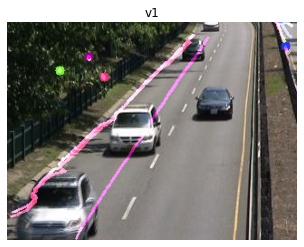

In [8]:
v1 = cv.imread('./output/highway/pics/1_v1.jpg')
v1_rgb = cv.cvtColor(v1, cv.COLOR_BGR2RGB)
plt.imshow(v1_rgb)
plt.axis("off")
plt.title('v1')
plt.show();

Como se observa, el flujo óptico captado es poco en comparación con la cantidad de coches que circulan realmente en el video. Se sospecha que esto podría ser por la distancia mínima entre esquinas válidas y el umbral mínimo de calidad necesario en el algoritmo de Shi Tomasi. Así que en el siguiente intento se rebajan estos parámetros. 

Por otro lado es curioso ver como capta como puntos válidos algunas ramas de los árboles y realiza su seguimiento. Al no tener mucho movimiento, su línea de flujo se resume en un círculo (elemento geométrico que se añade al final de cada línea de flujo según el código). Por otro lado, tambíen es interesante ver como se captan lo movimientos de los coches de la otra vía en la esquina superior derecha. 

#### v2: modificación de parámetros Shi Tomasi 

En este segundo intento se modificaron los parámetros del detector de esquinas de Shi Tomasi. Fueron los sigueintes: 

* qualityLevel = 0.3 -> 0.2

* minDistance = 7 -> 3

* blockSize = 7 -> 3

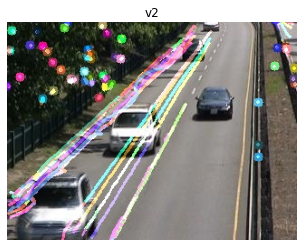

In [9]:
v2 = cv.imread('./output/highway/pics/1_v2.jpg')
v2_rgb = cv.cvtColor(v2, cv.COLOR_BGR2RGB)
plt.imshow(v2_rgb)
plt.axis("off")
plt.title('v2')
plt.show();

Se contempla que al rebajar las condiciones para considerar esquinas o puntos a seguir, las líneas de flujo aumentan. Ahora si que parecen ser en cierta manera coherentes con la cantidad de coches que circulan en el vídeo, al menos en el carril izquerdo. En el carril derecho no capta ningún coche de los que circulan. Esto es problema del algorimo de detección de esquinas, pero si se continúan bajando las condiciones de validación de un punto la imagen cotendría demasiado ruido (i.e, objetos de los cuales no se desea realizar un seguimiento). 

Al dismiuir las condiciones de selección de _features_ , ahora se capta mucho más ruido proveniente del árbol y también del guardarraíles y la tierra de la derecha. 

#### v3: modificación sobre los parámetros de Lucas - Kanade

En este útlimo intento se modificaron los parámetros del algoritmos de Lucas y Kanade. Para ello se cambió el `winSize` de (15,15) a (5,5).

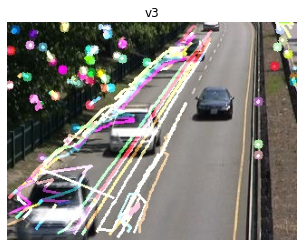

In [10]:
v3 = cv.imread('./output/highway/pics/1_v3.jpg')
v3_rgb = cv.cvtColor(v3, cv.COLOR_BGR2RGB)
plt.imshow(v3_rgb)
plt.axis("off")
plt.title('v3')
plt.show();

En este último caso se decidió experimentar un poco con los parámetros del algoritmo de Lucas y Kanade. Como se ve, al reducir el tamaño de la ventana de cálculo del flujo óptico, se dan más errores en su cálculo. Aparecen líneas más irregulares que no coinciden con el movimiento de los vehículos. 

### ¿Qué tareas podríamos resolver aplicando flujo óptico _sparse_ ? ¿Qué problemas tendríamos a la hora de realizar una implementación real?

En cuanto a la primera pregunta, podría decirse de manera general que el flujo óptico _sparse_ puede aplicarse a situaciones donde se quieren estudiar las relaciones entre frame consecutivos, como el movimiento de los coches o cambios en la postura humana. También podría hacerse un seguimiento de objetos o clases específicas de estos cambiando los puntos característicos ( _features_ ) a seguir en la imagen. Por ejemplo, quizás podría diseñarse un flujo óptico que solo siguiente camiones o motos seleccionando correctamente los puntos a seguir. Sin embargo me imagino que ello requiere de métodos más potentes y complejos. Por otra parte, el flujo óptico constituye también un primer paso fundamental para procesos o algoritmos más complejos y de alto nivel, como por ejemplo en tareas de reconocimiento facial o la navegación autónoma de vehículos. Otras tareas podrían incluir el registro de imágenes o la interacción digital (como con el "Eye Toy" desarrollado). 

Respecto a la segunda pregunta, en primer lugar se tendría que estudiar el ambiente o contexto en el cual se implanta el modelo, con especial atención a las condiciones lumínicas (cambios bruscos o rápidos en la iluminación)  o por ejemplo las condiciones meteorológicas más comunes (una zona de mucho viento o lluvia podría ocasionar problemas al algoritmo). Por otro lado, hay que tener en cuenta las limitaciones inherentes al algoritmo: evitar el seguimiento de zonas planas (probelma de la apertura), asegurar en cierta forma que el movimiento de los objetos entre frames no es muy grande, mismo movimiento dentro de la ventana de cálculo y, como ya se ha comentado, iluminación constante. Cabe decir que salvo el primer problema (la apertura), el resto son problemas relacionados con el algoritmo de Lucas y Kanade. Quizás otro método requiera de otras necesidades. 

## Ejercicio 2

En este segundo ejercicio se plantea realizar lo mismo que en el ejercicio anterior pero, en lugar de emplear puntos resultantes del método de Shi Tomasi, se empleará una malla de puntos constantes sobre la que se mostrará el flujo. Además el resultado se mostrará sobre dos secuencias distintas. Los resultados pueden verse en el directorio `./output/highway/videos/` o bien `./output/canoe/videos/`.

En este caso, es más conveniente tratar la secuencia de imágenes descargada como un video. Así que el primer paso de todos será convertir dicha secuencia a un video sobre el que trabajar. De ello se encarga la función `convert_to_video`. Como entrada se define el directorio correspondiente a la secuencia deseada. La fucnión devuelve el tamaño del frame, con tal de poder crear una malla de puntos adecuada a este. 

In [11]:
def convert_to_video(folder):
    img_array = []
    for filename in sorted(os.listdir('./input/'+folder)):
        img = cv.imread('./input/' + folder + '/' + filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)


    out = cv.VideoWriter('video_'+folder+'.avi',cv.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
    return size

A continuación se define una función que se encargue de aplicar LK. Como entradas se definen el directorio del video deseado (highway o canoe) y la versión o experimento realizado `vx`. En este caso, al tratarse siempre de punto fijos, no se hace uso de la variable `st` para seleccionar aquellos puntos válidos. Siempre se mantienen los mismos. 

Como experiencia, mencionar que el la matriz de puntos sobre la que calcular el flujo tiene que tener una forma `(N,1,2)`, donde N es el número total de puntos, y tiene que se de tipo `float32`, sino no funciona. Además en este caso la máscara sobre al que se dibujan las líneas de flujo se inicia a 0 a cada iteración para no ir acumulando la información del movimiento, a diferencia del ejercicio anterior. 

La función finaliza con la creación de un nuevo video sobre el que se sobreescribe la malla de puntos y el flujo sobre la escena original. 

In [12]:
def apply_LK (folder, vx):
    cap = cv.VideoCapture('video_' + folder + '.avi')
    out = cv.VideoWriter('./output/' + folder + '/videos/video_OFGrid_' + vx + '.avi',cv.VideoWriter_fourcc(*'DIVX'), 15, size)
    ret, old_frame = cap.read()
    old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
    while(1):
        ret,frame = cap.read()
        mask = np.zeros_like(frame) # se renueva la máscara cada vez
        if ret:
            frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            # calculate optical flow
            p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, grid.astype('float32'), None, **lk_params)
            # draw the tracks
            for i,(new,old) in enumerate(zip(p1, grid)):
                a,b = new.ravel()
                c,d = old.ravel()
                mask = cv.line(mask, (a,b),(c,d), color[i].tolist(), 2)
               # frame = cv.circle(frame,(a,b),5,color[i].tolist(),-1)
            img = cv.add(frame,mask)
            out.write(img)
            # Now update the previous frame and previous points
            old_gray = frame_gray.copy()
            #p0 = good_new.reshape(-1,1,2)
        else: 
            break

    cap.release()
    out.release()

### Video de _highway_

Primero se convierte la secuencia de imágenes a video. 

In [13]:
size = convert_to_video('highway')

Se crea una malla de puntos acorde con el tamaño del frame. Entre puntos se deja un espacio de 10 o 20, dependiendo del experimento. Posteriormente se crea un vector aleatorio de colores para la representación de los puntos. 

In [14]:
grid = np.dstack(np.meshgrid(np.arange(size[0], step = 20), np.arange(size[1], step = 20))).reshape((-1,1,2))
color = np.random.randint(0,255,(grid.shape[0] + 50,3)) #más puntos en el grid -> más colores

Se aplica LK

In [15]:
apply_LK ('highway', 'v100')

#### Vídeos resultantes

#### Directorio: `./output/highway/videos/`

* video_OFGrid_v1 -> Parámetros de Shi Tomasi y LK por defecto y malla con espaciado de 20 píxeles. Parece detectar muy ligeramente el movimiento de los coches en determiandas ocasiones. Cuando estos llegan al borde inferior de la imagen, se destacan algunos valores del flujo más grandes de lo normal o esperado. 

* video_OFGrid_v2 -> Cambio del `winSize` de LK de (15,15) a (5,5). Algunos cálculos del flujo poseen magnituden muy grandes en toda la imagen.   

* video_OFGrid_v3 -> Reducción del grid, con un espacio de 10 a 20 píxeles entre puntos. Caso muy parecido al anterior. 

* video_OFGrid_v4 -> Cambio del `winSize` de LK (7,7). No parece haber gran cambio entre un tamaño de (5,5) y (7,7).

### Video de canoe

In [19]:
size = convert_to_video('canoe')

In [22]:
grid = np.dstack(np.meshgrid(np.arange(size[0], step = 10), np.arange(size[1], step = 10))).reshape((-1,1,2))
color = np.random.randint(0,255,(grid.shape[0] + 50,3)) #más puntos en el grid -> más colores

In [23]:
apply_LK ('canoe', 'v4')

#### Vídeo resultantes

#### Directorio: `./output/canoe/videos/`

* video_OFGrid_v1 -> parámetros por defecto LK y espaciado de la malla igual a 20. Parece detectar ligeramente el movimiento de la canoa cuando esta pasa, especialmente en los bordes. El movimiento del agua es captado de una forma muy parecida al _background_ del caso anterior, con pequeños movimientos parpadeante. 

* video_OFGrid_v2 -> malla con un espaciado igual a 20 y LK  con un tamaño de ventana `winSize` de (7,7). De nuevo, esto solo provoca que algunos cálculos del flujo se disparen.

* video_OFGrid_v3 -> malla con un espaciado igual a 10 y LK con un tamaño de ventana `winSize` de (5,5). Al añadir más puntos sobre la malla, parece que el movimiento de la canoa se detecta un poco mejor. Sin embargo, sigue habiendo muchos cálculos erróneos del flujo. 

* video_OFGrid_v4 -> malla con un espaciado igual a 10 y LK con un tamaño de ventana `winSize` de (15,15). Parece ser como mejor se detecta el movimiento de la canoa sin que haya cálculos disparados del flujo. 

## Conclusiones 

Por un lado, Los resultados del cálculo del flujo con la malla no son tan vistosos como se esperaba. El movimiento se capta únicamente con pequeñas líneas saliente de los puntos. Sin embargo, esto tiene sentido, ya que entre frame y frame, los objetos, los cuales no van a gran velocidad, no se desplazan lo suficiente como para poder dibujar líneas más largas. Al fin y al cabo, la linea viene definida por su origen (los puntos estáticos de la malla) y su final (los puntos `p1` de desplazamiento respecto de su origen). En un principio, se pensó que podría haber algún error y no se estaba captando bien el movimiento. Después, al razonar, se llegó a esta conclusión. 

Un factor con el que se ha experimentado es el tamaño de la ventana donde se calcula el flujo óptico. Cabe recordar que se asume que el movimiento dentro de esta ventana es el mismo en todos los píxeles. Por lo tanto, parece claro que a cuánto más lejos estén los objetos más pequeña tendrá que ser esta ventana. Sin embargo, a cuánto más cerca, no necesariamente tiene que ser más grande. En esta práctica, se ha observado que cuando se disminuye el tamaño de la ventana, aparecen cálculos erroneos del flujo con valores muy elevados. 